In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from google.colab import drive

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/Dataset'
IMG_SIZE = 227
BATCH_SIZE = 16
TRAIN_RATIO = 0.7

# Bộ lọc cho tập Huấn luyện: Có Augmentation để chống Overfitting
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0., contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Bộ lọc cho tập Kiểm tra: Chỉ chuẩn hóa, KHÔNG biến đổi ngẫu nhiên
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(DATA_DIR, transform=val_transforms)

# Lấy danh sách index và xáo trộn ngẫu nhiên
num_images = len(train_dataset)
indices = list(range(num_images))
split = int(TRAIN_RATIO * num_images)

np.random.seed(42) # Giữ kết quả xáo trộn cố định để tái lập thực nghiệm
np.random.shuffle(indices)

train_idx, val_idx = indices[:split], indices[split:]

# Tạo Subset: Trích xuất các tấm ảnh tương ứng từ bộ dataset tương ứng
train_data = Subset(train_dataset, train_idx)
val_data = Subset(val_dataset, val_idx)

# Khởi tạo DataLoader
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

# Kiểm tra kết quả
print(f"--- Kết quả nạp dữ liệu ---")
print(f"Tổng số ảnh: {num_images}")
print(f"Số lớp (người): {len(train_dataset.classes)}")
print(f"Tập Huấn luyện: {len(train_data)} ảnh")
print(f"Tập Kiểm tra: {len(val_data)} ảnh")

--- Kết quả nạp dữ liệu ---
Tổng số ảnh: 583
Số lớp (người): 30
Tập Huấn luyện: 408 ảnh
Tập Kiểm tra: 175 ảnh


In [ ]:
import torch.nn as nn
from torchvision import models

model = models.squeezenet1_1(pretrained=True)

# Đóng băng các lớp trích xuất đặc trưng (Features)
for param in model.features.parameters():
    param.requires_grad = False

# Chỉnh sửa cấu trúc lớp Classifier để phù hợp với 30 đối tượng
model.classifier[1] = nn.Conv2d(512, 30, kernel_size=(1, 1), stride=(1, 1))

# Cập nhật số lượng lớp đầu ra của mô hình
model.num_classes = 30

print(model)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


100%|██████████| 4.73M/4.73M [00:00<00:00, 88.3MB/s]

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [ ]:
import time
import copy
import torch.optim as optim
# 1. Cấu hình thiết bị (Ưu tiên GPU nếu có)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 2. Thiết lập tham số huấn luyện (Hyperparameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
num_epochs = 100 # Em có thể tăng lên 30-50 nếu cần độ chính xác cao hơn

# 3. Vòng lặp huấn luyện chính
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Mỗi Epoch có 2 giai đoạn: Train và Validation
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Vòng lặp qua dữ liệu theo từng Batch
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # Xóa gradient cũ

                # Forward pass (Tính toán đầu ra)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + Optimize nếu là giai đoạn train
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / (len(train_data) if phase == 'train' else len(val_data))
            epoch_acc = running_corrects.double() / (len(train_data) if phase == 'train' else len(val_data))

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Lưu lịch sử để vẽ đồ thị sau này
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            # Lưu lại trọng số tốt nhất (Best Model)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Huấn luyện hoàn tất trong {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Độ chính xác cao nhất (Best Val Acc): {best_acc:4f}')

    # Tải trọng số tốt nhất về model
    model.load_state_dict(best_model_wts)
    return model, history

# 4. Bắt đầu chạy huấn luyện
model, history = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# 5. Lưu mô hình đã huấn luyện xong
torch.save(model.state_dict(), 'face_recognition_squeezenet.pth')
print("Đã lưu file model: face_recognition_squeezenet.pth")

Epoch 1/100
----------
train Loss: 3.3935 Acc: 0.0564
val Loss: 3.3390 Acc: 0.0800

Epoch 2/100
----------
train Loss: 3.2744 Acc: 0.0760
val Loss: 3.2719 Acc: 0.1086

Epoch 3/100
----------
train Loss: 3.2333 Acc: 0.1152
val Loss: 3.2111 Acc: 0.1143

Epoch 4/100
----------
train Loss: 3.1338 Acc: 0.1520
val Loss: 3.1631 Acc: 0.1429

Epoch 5/100
----------
train Loss: 3.0853 Acc: 0.1422
val Loss: 3.1074 Acc: 0.1543

Epoch 6/100
----------
train Loss: 3.0026 Acc: 0.1716
val Loss: 3.0616 Acc: 0.1600

Epoch 7/100
----------
train Loss: 2.9306 Acc: 0.2108
val Loss: 3.0157 Acc: 0.1714

Epoch 8/100
----------
train Loss: 2.8835 Acc: 0.2304
val Loss: 2.9634 Acc: 0.1943

Epoch 9/100
----------
train Loss: 2.7998 Acc: 0.2721
val Loss: 2.9260 Acc: 0.2114

Epoch 10/100
----------
train Loss: 2.7741 Acc: 0.2647
val Loss: 2.8835 Acc: 0.2286

Epoch 11/100
----------
train Loss: 2.6874 Acc: 0.3358
val Loss: 2.8404 Acc: 0.2400

Epoch 12/100
----------
train Loss: 2.6307 Acc: 0.3211
val Loss: 2.8096 Ac

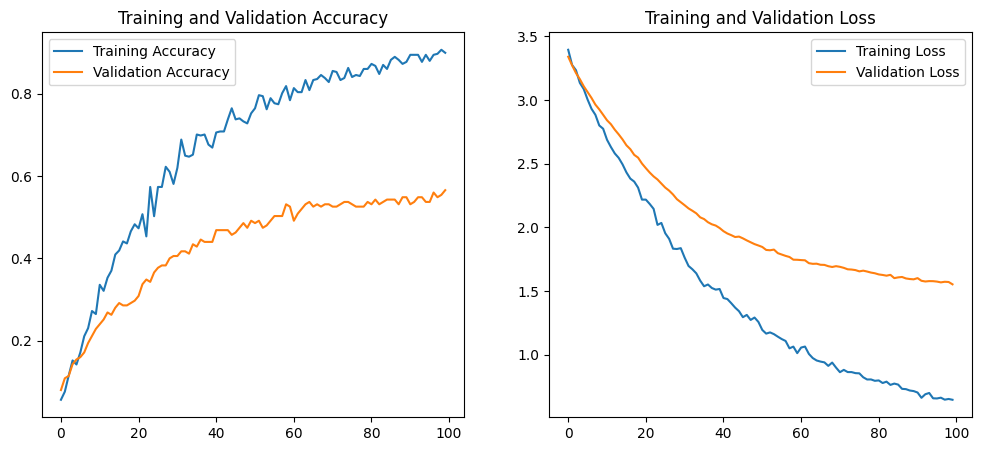

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Đồ thị Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Đồ thị Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_history(history)

Giai đoạn 2 - Fine-tuning

Epoch 1/50
----------
train Loss: 0.4952 Acc: 0.9044
val Loss: 1.4446 Acc: 0.6057

Epoch 2/50
----------
train Loss: 0.4242 Acc: 0.9216
val Loss: 1.4131 Acc: 0.6229

Epoch 3/50
----------
train Loss: 0.3974 Acc: 0.8922
val Loss: 1.4223 Acc: 0.6114

Epoch 4/50
----------
train Loss: 0.3577 Acc: 0.9069
val Loss: 1.4029 Acc: 0.6400

Epoch 5/50
----------
train Loss: 0.3232 Acc: 0.9216
val Loss: 1.4358 Acc: 0.6114

Epoch 6/50
----------
train Loss: 0.3505 Acc: 0.8873
val Loss: 1.4144 Acc: 0.6229

Epoch 7/50
----------
train Loss: 0.2970 Acc: 0.9167
val Loss: 1.4214 Acc: 0.6571

Epoch 8/50
----------
train Loss: 0.2944 Acc: 0.9314
val Loss: 1.4400 Acc: 0.6400

Epoch 9/50
----------
train Loss: 0.2863 Acc: 0.9118
val Loss: 1.4335 Acc: 0.6286

Epoch 10/50
----------
train Loss: 0.3224 Acc: 0.8995
val Loss: 1.4244 Acc: 0.6286

Epoch 11/50
----------
train Loss: 0.2563 Acc: 0.9191
val Loss: 1.4428 Acc: 0.6400

Epoch 12/50
----------
train Loss: 0.2708 Acc: 0.9167
val Loss: 1.4483 Acc: 0.6229

E

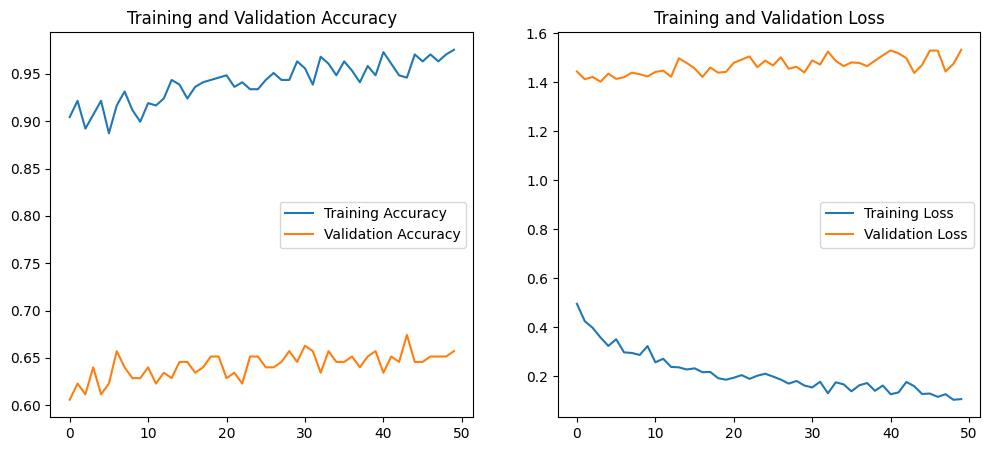

Đã lưu model phiên bản Fine-tuned cục bộ!


In [ ]:
# --- BƯỚC 1: CẤU HÌNH LẠI CƠ CHẾ ĐÓNG BĂNG ---

# Đóng băng toàn bộ trước để đưa về trạng thái an toàn
for param in model.parameters():
    param.requires_grad = False

# Mở khóa từ khối thứ 10 trở đi của phần Features (Gồm Fire 8 và Fire 9)
# Syntax: features[10:] chọn toàn bộ các lớp từ index 10 đến hết danh sách features
for param in model.features[10:].parameters():
    param.requires_grad = True

# Mở khóa toàn bộ phần Classifier (Lớp em đã độ lại cho 30 người)
for param in model.classifier.parameters():
    param.requires_grad = True

# --- BƯỚC 2: THIẾT LẬP LẠI QUÁ TRÌNH HỌC ---

# Dùng Learning Rate siêu nhỏ để tinh chỉnh, tránh làm hỏng kiến thức cũ
# Logic: Chỉ truyền những tham số đã mở khóa (requires_grad=True) vào optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

# Chạy thêm 30-50 Epoch để máy tập trung học chi tiết khuôn mặt
# Lưu vào biến history_partial để theo dõi đồ thị riêng
num_epochs_fine = 50
model, history_partial = train_model(model, criterion, optimizer, num_epochs=num_epochs_fine)

# --- BƯỚC 3: KIỂM TRA VÀ LƯU TRỮ ---

# Vẽ đồ thị kết quả của giai đoạn này
plot_history(history_partial)

# Lưu lại file model phiên bản xịn nhất (Giai đoạn 2)
torch.save(model.state_dict(), 'face_recognition_squeezenet_v2.pth')
print("Đã lưu model phiên bản Fine-tuned cục bộ!")

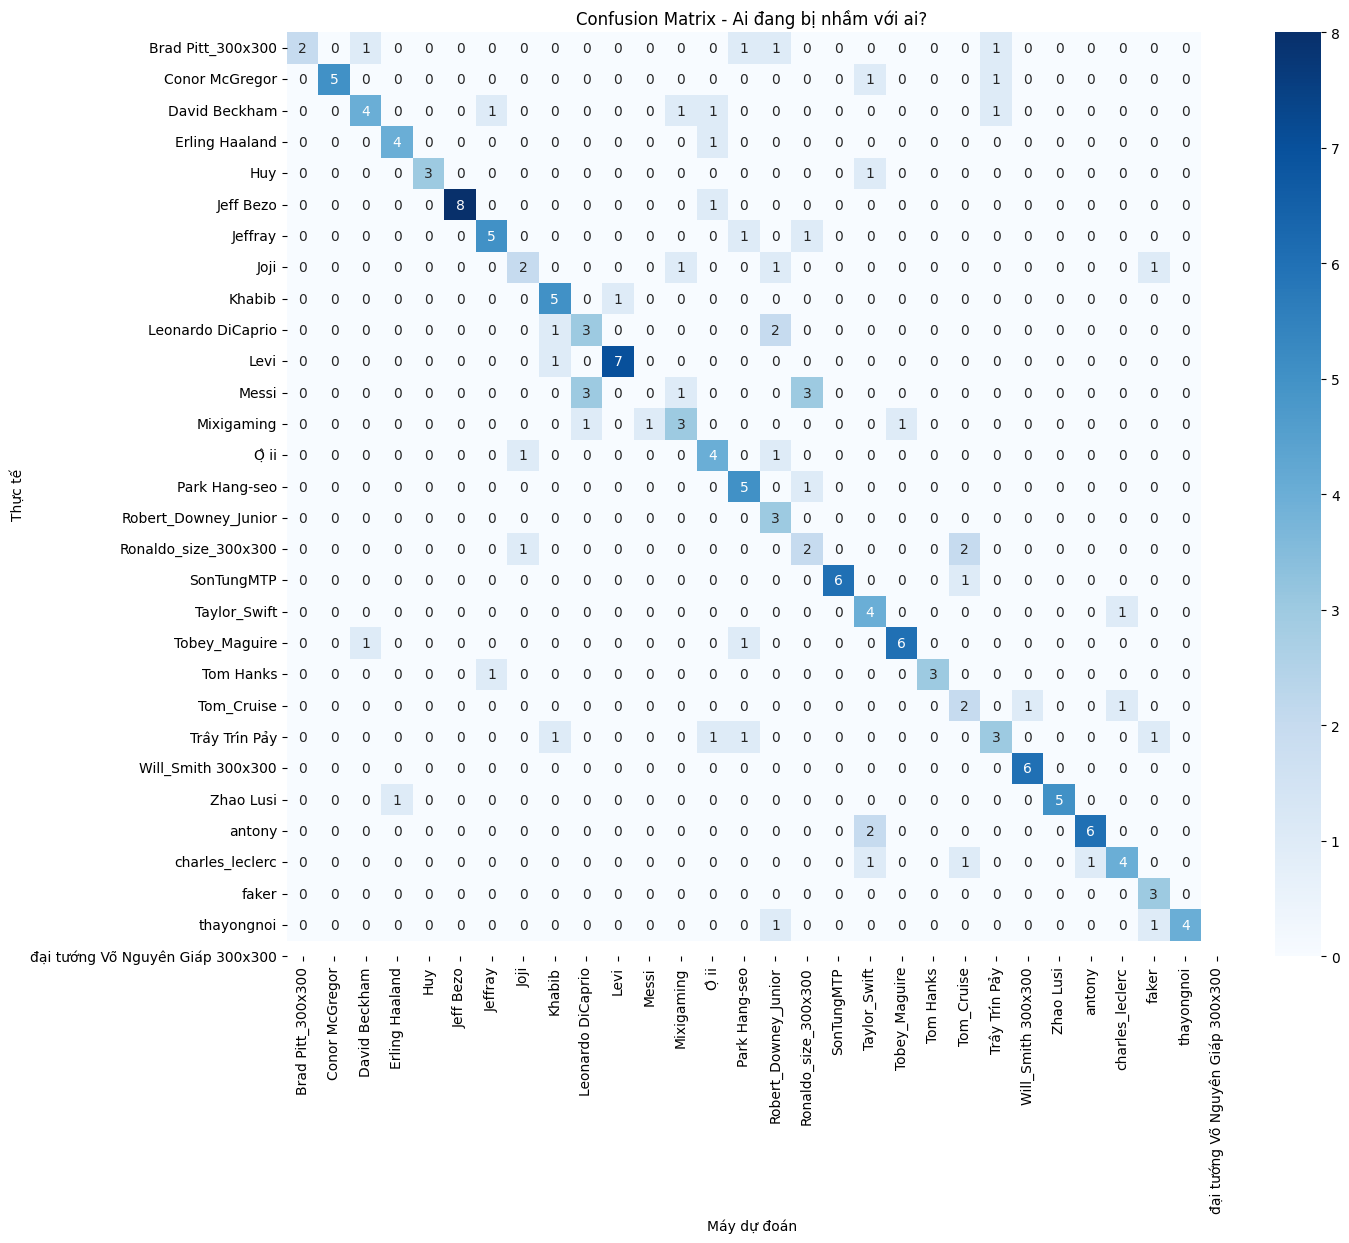

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
    plt.title("Confusion Matrix - Ai đang bị nhầm với ai?")
    plt.ylabel('Thực tế')
    plt.xlabel('Máy dự đoán')
    plt.show()

# Chạy lệnh
plot_confusion_matrix(model, val_loader, train_dataset.classes)

In [ ]:
# Chạy lệnh này để copy file từ bộ nhớ tạm sang thư mục Hoc_sau trên Drive
!cp face_recognition_squeezenet.pth /content/drive/MyDrive/Hoc_sau/

In [ ]:
!cp face_recognition_squeezenet_v2.pth /content/drive/MyDrive/Hoc_sau/

print("Đã sao chép bản v2 (Fine-tuned) vào Drive thành công!")

Đã sao chép bản v2 (Fine-tuned) vào Drive thành công!
